In [33]:
!pip install mxnet-cu100mkl

# __DenseNet - MXNet__

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

ctx = mx.gpu()

## __Getting the dataset__

In [0]:
transform = gluon.data.vision.transforms.ToTensor()

train_mnist = gluon.data.vision.CIFAR10(train = True).transform_first(transform)
test_mnist = gluon.data.vision.CIFAR10(train = False).transform_first(transform)

In [3]:
image, label = train_mnist[1]
print(image.shape)
print(label)

(3, 32, 32)
9


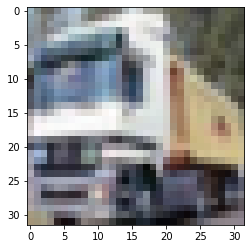

In [4]:
plt.imshow(image.transpose((1, 2, 0)).asnumpy())
plt.show()

## __Defining data loaders__

In [0]:
batch_size = 64
train_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = False)

## __Defining DenseNet Model Architecture__ 

### First we will define single densenet block and transition layer

In [0]:
class DenseBlock(nn.HybridBlock):
    def __init__(self, convs, channels):
        super(DenseBlock, self).__init__()

        self.model = nn.HybridSequential()
        for _ in range(convs):
            conv = nn.HybridSequential()
            conv.add(nn.BatchNorm())
            conv.add(nn.Activation('relu'))
            conv.add(nn.Conv2D(channels, kernel_size = 3, padding = 1))
            self.model.add(conv)

    def hybrid_forward(self, F, x):
        for layer in self.model:
            output = layer(x)
            x = F.concat(x, output, dim = 1)
        return x

class TransitionBlock(nn.HybridBlock):
    def __init__(self, channels):
        super(TransitionBlock, self).__init__()

        self.model = nn.HybridSequential()
        self.model.add(nn.BatchNorm())
        self.model.add(nn.Conv2D(channels, kernel_size = 1))
        self.model.add(nn.AvgPool2D(pool_size = 1, strides = 2))

    def hybrid_forward(self, F, x):
        return self.model(x)

### Visualizing single densenet block

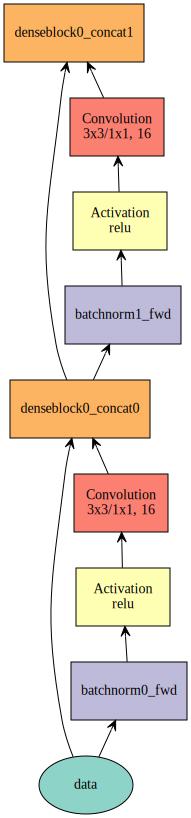

In [7]:
block = DenseBlock(2, 16)
block.initialize(ctx = ctx)
mx.viz.plot_network(block(mx.sym.var(name = 'data')), node_attrs={"fixedsize":"false"})

### Visualizing single transition block

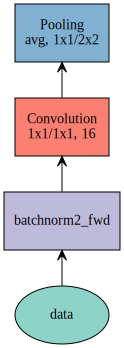

In [8]:
block = TransitionBlock(16)
block.initialize(ctx = ctx)
mx.viz.plot_network(block(mx.sym.var(name = 'data')), node_attrs={"fixedsize":"false"})

## __Defining the whole model__

In [9]:
model = nn.HybridSequential()

model.add(nn.Conv2D(64, kernel_size = 7, strides = 2, padding = 3))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = 3, strides = 2, padding = 1))

model.add(nn.Conv2D(channels = 64, kernel_size = 3, padding = 1))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))

channels, growth = 64, 32
convs = [4, 4, 4, 4] # only 4 dense block wich 4 conv layers

for i, num_convs in enumerate(convs):
    model.add(DenseBlock(num_convs, growth))
    channels += num_convs * growth
    if i != len(convs) - 1:
        channels //= 2
        model.add(TransitionBlock(channels))

model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.GlobalAvgPool2D())
model.add(nn.Dense(10))

model.initialize(mx.init.Xavier(), ctx)
model

HybridSequential(
  (0): Conv2D(None -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (2): Activation(relu)
  (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (4): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (6): Activation(relu)
  (7): DenseBlock(
    (model): HybridSequential(
      (0): HybridSequential(
        (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
        (1): Activation(relu)
        (2): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): HybridSequential(
        (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=Fal

## __Summarizing the model__

In [10]:
model.summary(image.expand_dims(0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 3, 32, 32)               0
            Conv2D-1                             (1, 64, 16, 16)            9472
         BatchNorm-2                             (1, 64, 16, 16)             256
        Activation-3                             (1, 64, 16, 16)               0
         MaxPool2D-4                               (1, 64, 8, 8)               0
            Conv2D-5                               (1, 64, 8, 8)           36928
         BatchNorm-6                               (1, 64, 8, 8)             256
        Activation-7                               (1, 64, 8, 8)               0
         BatchNorm-8                               (1, 64, 8, 8)             256
        Activation-9                               (1, 64, 8, 8)               0
           Conv2D-10        

## __Visializing model architecture__

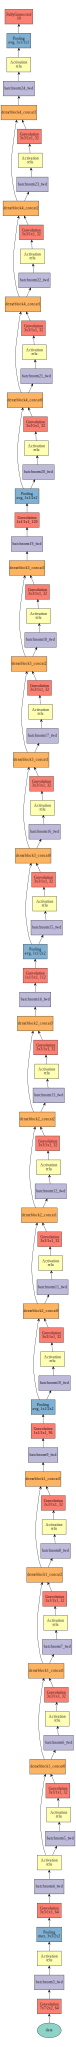

In [11]:
mx.viz.plot_network(model(mx.sym.var(name = 'data')), node_attrs={"fixedsize":"false"})

In [0]:
model.hybridize()

## __Defining our objective loss and optimizer__

In [0]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

## __Training the model__

In [14]:
epochs = 10
batches = len(train_data)
acc = mx.metric.Accuracy()

for epoch in range(epochs):
    acc.reset()
    cum_loss = 0.0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        acc.update(labels, outputs)
    
    print(f'Epoch: {epoch + 1} | Loss: {cum_loss.asscalar()/batches:.5f} | Training Accuracy: {acc.get()[1]:.5f}')

Epoch: 1 | Loss: 1.33812 | Training Accuracy: 0.52020
Epoch: 2 | Loss: 0.98833 | Training Accuracy: 0.64990
Epoch: 3 | Loss: 0.84358 | Training Accuracy: 0.70448
Epoch: 4 | Loss: 0.75304 | Training Accuracy: 0.73344
Epoch: 5 | Loss: 0.66846 | Training Accuracy: 0.76564
Epoch: 6 | Loss: 0.59882 | Training Accuracy: 0.78892
Epoch: 7 | Loss: 0.53135 | Training Accuracy: 0.81416
Epoch: 8 | Loss: 0.47111 | Training Accuracy: 0.83370
Epoch: 9 | Loss: 0.42550 | Training Accuracy: 0.84996
Epoch: 10 | Loss: 0.36797 | Training Accuracy: 0.86986


## __Testing the model__

In [15]:
acc.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    acc.update(labels, outputs)
acc.get()

('accuracy', 0.8795)